# Lab | Sequence Modeling with LSTM

In [1]:
# !wget https://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

2025-09-17 13:56:28.681428: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load the dataset
df = pd.read_csv('dataset.csv')  # Make sure your CSV file is in the correct path
text_col = 'Text'
label_col = 'Category'

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (1490, 3)


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


# =============================================================================
# EXERCISE 1: TEXT PREPROCESSING
# =============================================================================

In [4]:

def clean_text(text):
    """
    Clean and preprocess text data
    TODO: Complete this function to:
    1. Convert text to lowercase
    2. Remove all characters except letters and spaces using regex
    3. Return the cleaned text
    """
    # TODO: Convert to lowercase
    text = text.lower()
    
    # TODO: Remove non-alphabetic characters (keep only letters and spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    
    return text

# Apply text cleaning
df[text_col] = df[text_col].astype(str).apply(clean_text)

print("Sample cleaned texts:")
print(df[text_col].head(3).tolist())

Sample cleaned texts:
['worldcom exboss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness  cynthia cooper  worldcom s exhead of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in  her warnings led to the collapse of the firm following the discovery of an bn bn accounting fraud mr ebbers has pleaded not guilty to charges of fraud and conspiracy  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early  and  she said andersen had given a  green light  to the procedures and practices used by worldcom mr ebber s la

# =============================================================================
# EXERCISE 2: LABEL ENCODING
# =============================================================================


In [5]:

# TODO: Initialize LabelEncoder and encode the labels
encoder = LabelEncoder()
df[label_col] = encoder.fit_transform(df[label_col])

num_classes = len(encoder.classes_)
print(f"Number of classes: {num_classes}")
print(f"Classes: {encoder.classes_}")

Number of classes: 5
Classes: ['business' 'entertainment' 'politics' 'sport' 'tech']



# =============================================================================
# EXERCISE 3: TEXT TOKENIZATION AND PADDING
# =============================================================================


In [6]:

# TODO: Initialize tokenizer with out-of-vocabulary token
tokenizer = Tokenizer(oov_token='<OOV>')

# TODO: Fit tokenizer on texts
tokenizer.fit_on_texts(df[text_col])

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print(f"Vocabulary size: {vocab_size}")

# TODO: Convert texts to sequences
sequences = tokenizer.texts_to_sequences(df[text_col])

# TODO: Pad sequences to max_len=100
max_len = 100
padded = pad_sequences(sequences, maxlen=max_len, padding='post')

print(f"Padded sequences shape: {padded.shape}")

Vocabulary size: 25379
Padded sequences shape: (1490, 100)



# =============================================================================
# EXERCISE 4: TRAIN-VALIDATION-TEST SPLIT
# =============================================================================


In [7]:
# TODO: Split data into train (70%), validation (15%), and test (15%)

# First split: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    padded, df[label_col], test_size=0.30, random_state=42, stratify=df[label_col]
)

# Second split: validation (15%) and test (15%) from temp (which is 30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (1043, 100)
Validation shape: (223, 100)
Test shape: (224, 100)


# =============================================================================
# EXERCISE 5: LOAD PRE-TRAINED EMBEDDINGS (OPTIONAL)
# ============================================================================


In [8]:
# TODO: Load GloVe embeddings

# =============================================================================
# EXERCISE 6: BUILD MODEL FUNCTION
# =============================================================================


In [9]:
# Build RNN or LSTM model
# TODO: Complete this function to build the neural network

# Set mixed precision (faster for RTX 3080)
mixed_precision.set_global_policy("mixed_float16")

# Choose core RNN type: "lstm" or "simplernn"
RNN_TYPE = "lstm"    # change to "simplernn" if desired
RNN_UNITS = 128
EMBED_DIM = 100
EPOCHS = 40
BATCH_SIZE = 2048

BASE_LR = 1e-3
SCALE_REF = 64
lr = BASE_LR * (BATCH_SIZE / SCALE_REF)

num_classes = df[label_col].nunique()

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBED_DIM, mask_zero=True))

if RNN_TYPE.lower() == "simplernn":
    model.add(SimpleRNN(RNN_UNITS))
else:
    model.add(LSTM(RNN_UNITS))

# Classification head
if num_classes > 2:
    model.add(Dense(num_classes, activation='softmax'))
    loss = 'sparse_categorical_crossentropy'   # labels are integer-encoded
else:
    model.add(Dense(1, activation='sigmoid'))
    loss = 'binary_crossentropy'


optimizer = Adam(learning_rate=lr)

model.build(input_shape=(None, max_len))
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()

# Early stopping
es = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

I0000 00:00:1758110190.795236   55105 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:09:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     2,537,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,655,793 (10.13 MB)

 Trainable params: 2,655,793 (10.13 MB)

 Non-trainable params: 0 (0.00 B)

# =============================================================================
# EXERCISE 7: MODEL TRAINING AND EVALUATION
# =============================================================================


In [10]:
# TODO: Train the model

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es],
    verbose=1
)

Epoch 1/40


2025-09-17 13:56:33.363044: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.1965 - loss: 1.6096 - val_accuracy: 0.2556 - val_loss: 1.5622
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.2819 - loss: 1.4959 - val_accuracy: 0.2287 - val_loss: 2.6236
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.2867 - loss: 2.2338 - val_accuracy: 0.3274 - val_loss: 2.8568
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.3183 - loss: 2.6194 - val_accuracy: 0.3274 - val_loss: 2.8568
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.3183 - loss: 2.6194 - val_accuracy: 0.3587 - val_loss: 1.6308
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.4516 - loss: 1.1330 - val_accuracy: 0.4529 - val_loss: 1.3820
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7584 - loss: 0.8326 - val_accuracy: 0.4753 - val_loss: 1.3245
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8476 - loss: 0.6600 - val_accuracy: 0.5022 - val_loss: 1.3663
Epoch 

In [11]:
# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test — loss: {test_loss:.4f}, acc: {test_acc:.4f}")

Test — loss: 1.4464, acc: 0.6250


In [12]:
# TODO: Make predictions on test set

y_pred_probs = model.predict(X_test, batch_size=BATCH_SIZE)
y_pred = np.argmax(y_pred_probs, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


In [13]:
# TODO: Generate classification report

print(classification_report(y_test, y_pred, target_names=encoder.classes_, zero_division=0))

               precision    recall  f1-score   support

     business       0.67      0.57      0.62        51
entertainment       0.56      0.49      0.52        41
     politics       0.62      0.61      0.62        41
        sport       0.69      0.73      0.71        52
         tech       0.56      0.72      0.63        39

     accuracy                           0.62       224
    macro avg       0.62      0.62      0.62       224
 weighted avg       0.63      0.62      0.62       224



In [14]:
# TODO: Generate confusion matrix

cm = confusion_matrix(y_test, y_pred)


# =============================================================================
# EXERCISE 8: VISUALIZATION
# =============================================================================


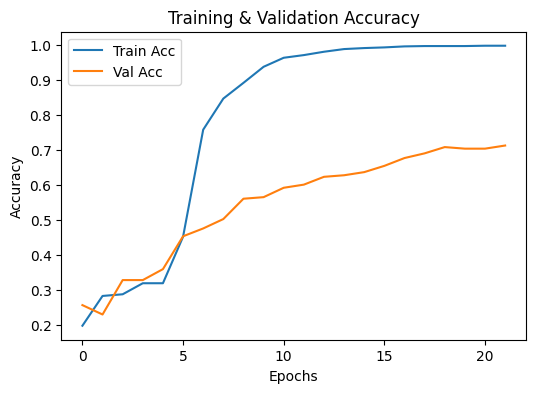

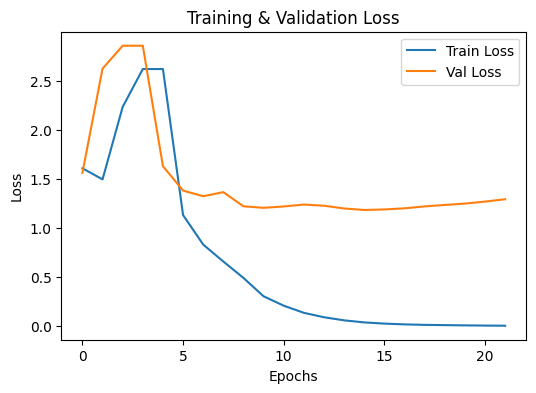

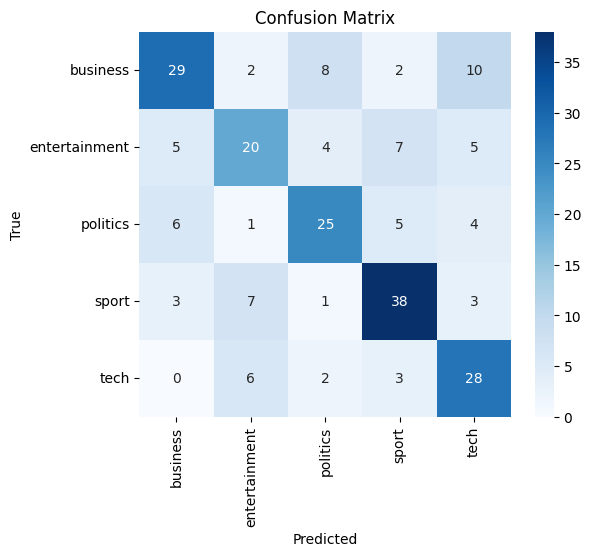

In [15]:
# TODO: Plot training accuracy
# ------------------------------
# Plot training & validation accuracy
# ------------------------------
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# TODO: Plot training loss
# ------------------------------
# Plot training & validation loss
# ------------------------------
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# TODO: Plot confusion matrices
# ------------------------------
# Plot confusion matrix
# ------------------------------
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# =============================================================================
# EXERCISE 9: RESULTS ANALYSIS
# =============================================================================


In [16]:
# TODO: Add best validation metrics to results
# Extract best validation accuracy and loss
best_val_acc = max(history.history['val_accuracy'])
best_val_loss = min(history.history['val_loss'])

# Store in results
results = {
    "best_val_accuracy": best_val_acc,
    "best_val_loss": best_val_loss,
    "test_accuracy": test_acc,
    "test_loss": test_loss
}

print("Results summary:")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

Results summary:
best_val_accuracy: 0.7130
best_val_loss: 1.1845
test_accuracy: 0.6250
test_loss: 1.4464


EXERCISE COMPLETE!